### Importing Libraries

In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [2]:
!unzip "/content/drive/MyDrive/Data Mining Project/archive.zip" -d "/content/DataMiningProject"

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: /content/DataMiningProject/train/sad/Training_65329617.jpg  
  inflating: /content/DataMiningProject/train/sad/Training_65338712.jpg  
  inflating: /content/DataMiningProject/train/sad/Training_65338797.jpg  
  inflating: /content/DataMiningProject/train/sad/Training_65387162.jpg  
  inflating: /content/DataMiningProject/train/sad/Training_65404494.jpg  
  inflating: /content/DataMiningProject/train/sad/Training_65426218.jpg  
  inflating: /content/DataMiningProject/train/sad/Training_65430136.jpg  
  inflating: /content/DataMiningProject/train/sad/Training_65437377.jpg  
  inflating: /content/DataMiningProject/train/sad/Training_6545735.jpg  
  inflating: /content/DataMiningProject/train/sad/Training_65463385.jpg  
  inflating: /content/DataMiningProject/train/sad/Training_65473985.jpg  
  inflating: /content/DataMiningProject/train/sad/Training_65502829.jpg  
  inflating: /content/DataMiningProject/train/sad/Training_6550535

In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tensorflow.keras.preprocessing import image
import glob
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D, Input, Dense, Flatten, MaxPool2D, BatchNormalization, Dropout
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import resnet50, vgg16 

### Exploring Dataset

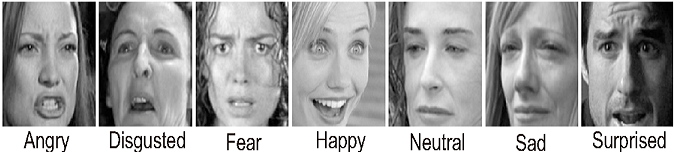

FER-2013 veri seti 28.000 tane etiketli yüz görselinden oluşmaktadır. Bu verilerin 28709'u eğitim için ayrılmışken 7178'i ise test için ayrılmıştır. FER veri setindeki görseller 48x48 boyutuna sahip gri-seviye görsellerdir. Bu veri setindeki ifadeler 7 duygu durumundan biriyle etiketlenmişlerdir. Bunlar angry(kızgın), disgusted(iğrenme), fear(korku), happy(mutlu), neutral(nötr), sad(üzgün) ve surprised(şaşkın) şeklindedir. 

In [4]:
train_data_path = "/content/DataMiningProject/train" 
test_data_path =  "/content/DataMiningProject/test"


print("Veri setindeki sınıflar:")
for i in os.listdir(train_data_path):
    print(i)

Veri setindeki sınıflar:
sad
angry
happy
neutral
fear
surprise
disgust


In [5]:
def number_of_expressions_in_each_class(data_path):
    
    exp_dict = {}
    number_of_images=0
    
    for exp in os.listdir(data_path):
        full_path = os.path.join(data_path, exp)
        exp_dict[exp] = len(os.listdir(full_path))
        number_of_images += len(os.listdir(full_path))
        
    return number_of_images, exp_dict      
        
number_of_train_images, train_dict = number_of_expressions_in_each_class(train_data_path)
number_of_test_images, test_dict = number_of_expressions_in_each_class(test_data_path)

df_train = pd.DataFrame(train_dict, index = ["train_seti"])
df_test = pd.DataFrame(test_dict, index = ["test_seti"])

print(df_train, "\n")
print(df_test)

             sad  angry  happy  neutral  fear  surprise  disgust
train_seti  4830   3995   7215     4965  4097      3171      436 

            sad  angry  happy  neutral  fear  surprise  disgust
test_seti  1247    958   1774     1233  1024       831      111


In [6]:
print(f"Toplam eğitim seti: {number_of_train_images}")
print(f"Toplam test seti: {number_of_test_images}")

Toplam eğitim seti: 28709
Toplam test seti: 7178


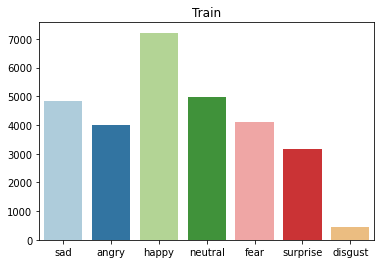

In [7]:
sns.barplot(data = df_train, palette="Paired");
plt.title("Train");

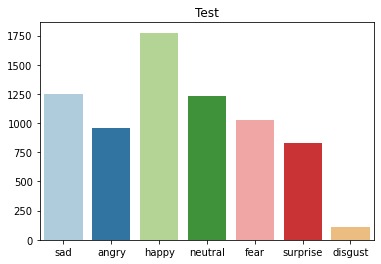

In [8]:
sns.barplot(data = df_test, palette="Paired");
plt.title("Test");

TRAIN


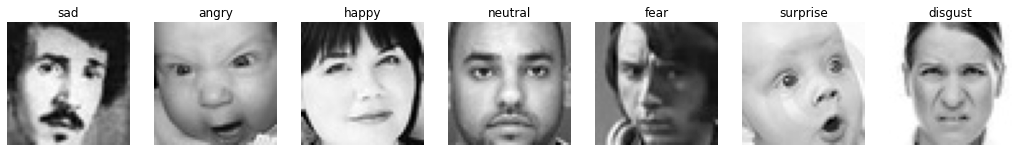

In [9]:
# Veri setinden bazı örneklere bakalım.
def plot_some_images(train_data_path):
    plt.figure(figsize=(18,22))

    i=1
    j=7
    k=1
    image_size=(48,48)

    for exp in os.listdir(train_data_path):
        full_path = os.path.join(train_data_path, exp)
        images_path = glob.glob(os.path.join(full_path, '*.jpg'))
        random_image_name = random.choice(images_path)
        #print(random_image_name)
        img = image.load_img(random_image_name, target_size=image_size, color_mode="grayscale")

        plt.subplot(i,j,k)
        k+=1
        plt.imshow(img, cmap="gray")
        plt.title(exp)
        plt.axis("off")
        
print("TRAIN")
plot_some_images(train_data_path)

### Creating Generator

In [10]:
def create_generator(batch_size, train_data_path, test_data_path):
    
    target_size=(48,48)
    
    train_preprocesser = ImageDataGenerator(
        rescale = 1/255.,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        validation_split=0.2
    )
    
    train_generator = train_preprocesser.flow_from_directory(
        train_data_path,
        class_mode = "categorical",
        color_mode = "grayscale",
        target_size = target_size,
        shuffle = True,
        batch_size = batch_size,
        subset = "training"
    )
    
    val_generator = train_preprocesser.flow_from_directory(
        train_data_path,
        class_mode = "categorical",
        color_mode = "grayscale",
        target_size = target_size,
        shuffle = True,
        batch_size = batch_size,
        subset = "validation"
    )
    
    test_preprocesser = ImageDataGenerator(rescale=1./255,
                                           width_shift_range=0.1,
                                           height_shift_range=0.1,
                                           horizontal_flip=True)
    
    test_generator = test_preprocesser.flow_from_directory(
        test_data_path,
        class_mode = "categorical",
        color_mode = "grayscale",
        target_size=target_size,
        shuffle = True,
        batch_size = batch_size
    )
    
    return train_generator, val_generator, test_generator

In [11]:
batch_size = 64

train_generator, val_generator, test_generator = create_generator(batch_size, train_data_path, test_data_path)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [12]:
train_generator.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

### Building Models

#### My CNN Model

In [ ]:
def CNN_model(number_of_classes):
    
    model = models.Sequential()
    
    model.add(Conv2D(32, (3,3), padding="same", activation="relu", input_shape=(48,48,1)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3,3), padding="same", activation="relu", input_shape=(48,48,1)))
    model.add(BatchNormalization())
    model.add(MaxPool2D())
    model.add(Dropout(0.3))
    
    model.add(Conv2D(128, (3,3), padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3,3), padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPool2D())
    model.add(Dropout(0.3))
    
    model.add(Conv2D(512, (3,3), padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(Conv2D(1024, (3,3), padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPool2D())
    model.add(Dropout(0.3))
    
    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Dense(512, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Dense(number_of_classes, activation="softmax"))
    
    return model

In [ ]:
number_of_classes = train_generator.num_classes
model = CNN_model(number_of_classes)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 batch_normalization_15 (Bat  (None, 48, 48, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_12 (Conv2D)          (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_16 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                      

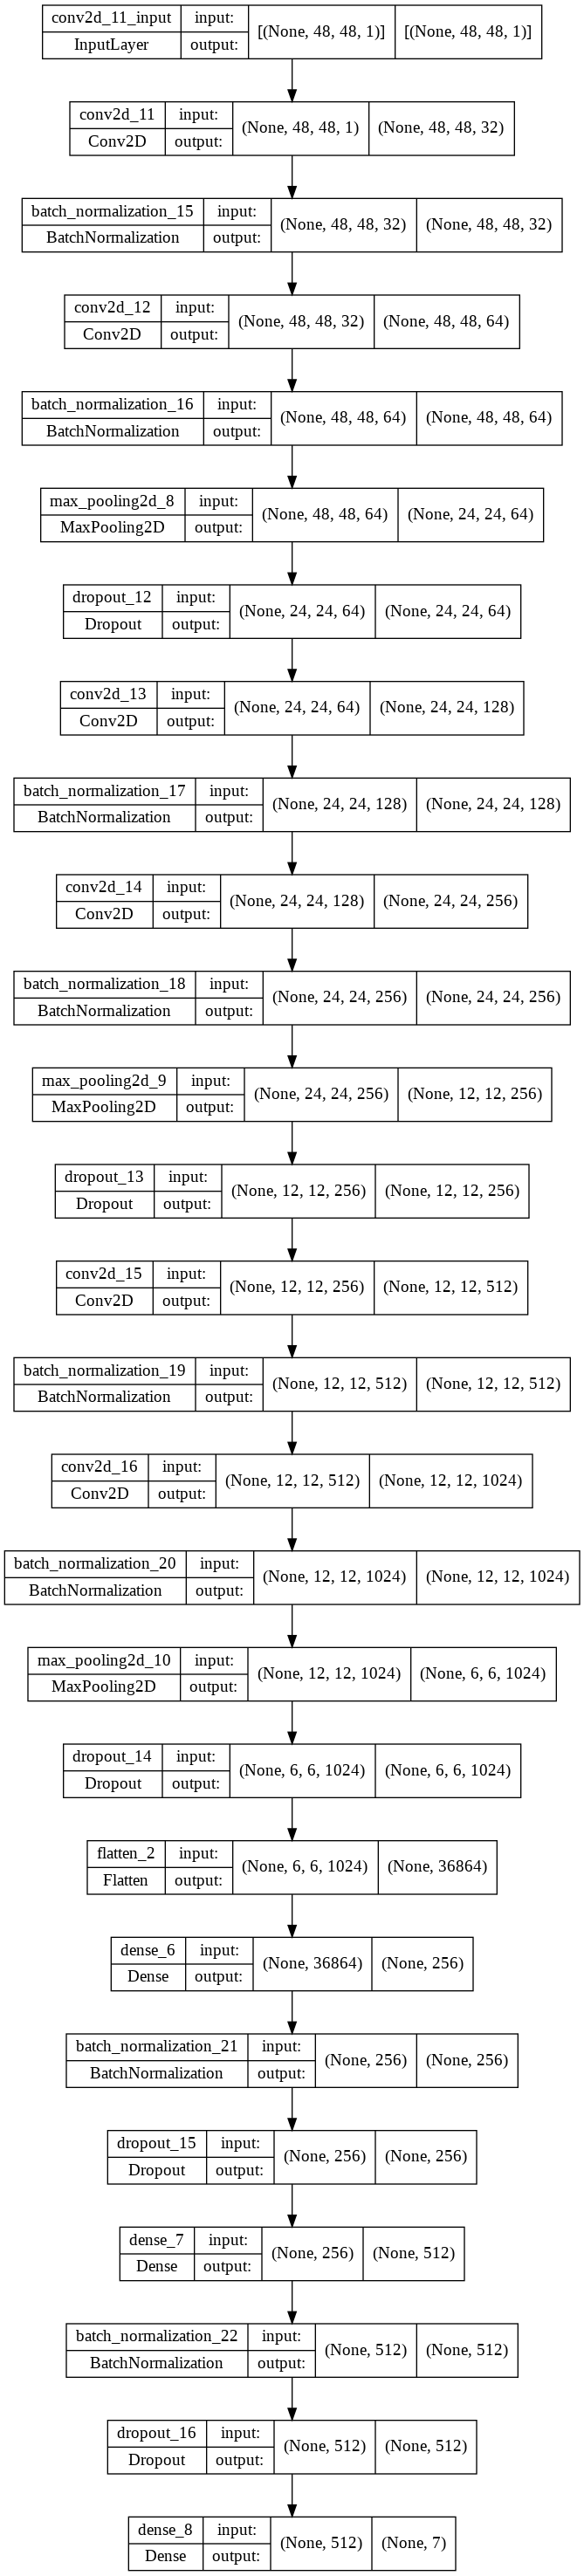

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
epochs = 50

path_to_save_model = "/content/DataMiningProject/Models/my_cnn_2.h5" # dropout 0.2 hali

ckpnt_saver = ModelCheckpoint(
    filepath = path_to_save_model,
    monitor = "val_accuracy",
    mode="max",
    save_best_only = True,
    save_freq = "epoch",
    verbose=1
    )

model.compile(optimizer = "Adam",
              loss = "categorical_crossentropy",
              metrics = ["accuracy"]
              )

history = model.fit(train_generator, 
          epochs = epochs,
          batch_size = batch_size,
          validation_data = val_generator,
          callbacks = [ckpnt_saver]
          )

Epoch 1/50
359/359 [==============================] - ETA: 0s - loss: 2.0961 - accuracy: 0.2386
Epoch 1: val_accuracy improved from -inf to 0.25135, saving model to /content/DataMiningProject/Models/my_cnn_2.h5
359/359 [==============================] - 30s 80ms/step - loss: 2.0961 - accuracy: 0.2386 - val_loss: 1.9154 - val_accuracy: 0.2513
Epoch 2/50
359/359 [==============================] - ETA: 0s - loss: 1.7044 - accuracy: 0.3433
Epoch 2: val_accuracy improved from 0.25135 to 0.37851, saving model to /content/DataMiningProject/Models/my_cnn_2.h5
359/359 [==============================] - 28s 78ms/step - loss: 1.7044 - accuracy: 0.3433 - val_loss: 1.6987 - val_accuracy: 0.3785
Epoch 3/50
359/359 [==============================] - ETA: 0s - loss: 1.5029 - accuracy: 0.4175
Epoch 3: val_accuracy improved from 0.37851 to 0.43355, saving model to /content/DataMiningProject/Models/my_cnn_2.h5
359/359 [==============================] - 28s 78ms/step - loss: 1.5029 - accuracy: 0.4175 - va

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [ ]:
def show_acc_and_loss(model):    
    plt.figure(figsize=(14,6))

    train_acc = model.history["accuracy"]
    train_loss = model.history["loss"]

    plt.subplot(1,2,1)
    plt.plot(model.history["accuracy"])
    plt.plot(model.history["val_accuracy"])
    plt.title("Train and Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(["Train", "Validation"])

    plt.subplot(1,2,2)
    plt.plot(model.history["loss"])
    plt.plot(model.history["val_loss"])
    plt.title("Train and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(["Train", "Validation"])

    plt.show()

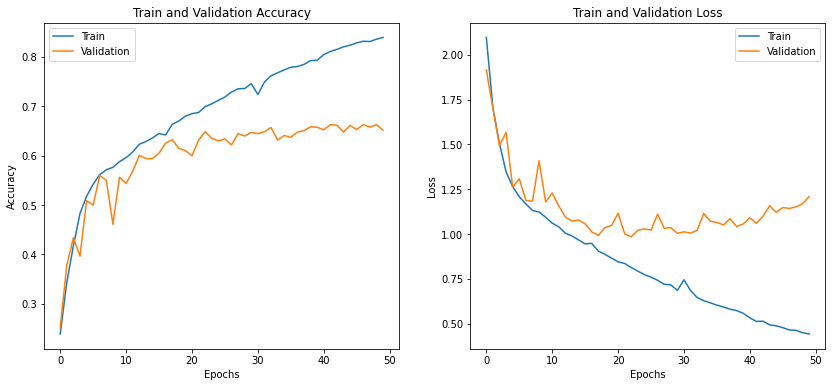

In [ ]:
show_acc_and_loss(history)

In [13]:
model = tf.keras.models.load_model("/content/DataMiningProject/Models/my_cnn_2.h5")

print("Evaluating train set: ")
model.evaluate(train_generator)

print("Evaluating test set: ")
model.evaluate(test_generator)

Evaluating train set: 
359/359 [==============================] - 849s 2s/step - loss: 0.3511 - accuracy: 0.8744
Evaluating test set: 
113/113 [==============================] - 262s 2s/step - loss: 1.0454 - accuracy: 0.6615


[1.0453505516052246, 0.661465585231781]

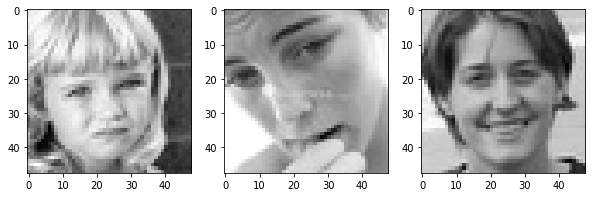

In [14]:
test_img_1 = image.load_img("/content/DataMiningProject/test/sad/PrivateTest_2552088.jpg", target_size = (48,48), color_mode = "grayscale")
test_img_2 = image.load_img("/content/DataMiningProject/test/fear/PrivateTest_3463701.jpg", target_size = (48,48), color_mode = "grayscale")
test_img_3 = image.load_img("/content/DataMiningProject/test/happy/PrivateTest_3579299.jpg", target_size = (48,48), color_mode = "grayscale")

plt.figure(figsize=(10,6))
plt.subplot(1,3,1)
plt.imshow(test_img_1, cmap="gray")
plt.subplot(1,3,2)
plt.imshow(test_img_2, cmap="gray")
plt.subplot(1,3,3)
plt.imshow(test_img_3, cmap="gray")

In [15]:
def prediction_on_test_image(model, test_img):   
    dictionary = train_generator.class_indices

    test_img = np.expand_dims(test_img, axis=0)
    test_img = test_img.reshape(1,48,48,1)
    result = model.predict(test_img)
    result = list(result[0])
    #print(result)

    img_index = result.index(max(result))

    key = [key for key,value in dictionary.items() if value==img_index]
    
    return key[0]

In [16]:
prediction_on_test_image(model, test_img_1)

'happy'

In [17]:
prediction_on_test_image(model, test_img_2)

'surprise'

In [18]:
prediction_on_test_image(model, test_img_3)

'happy'

TRAIN


<Figure size 720x1152 with 0 Axes>

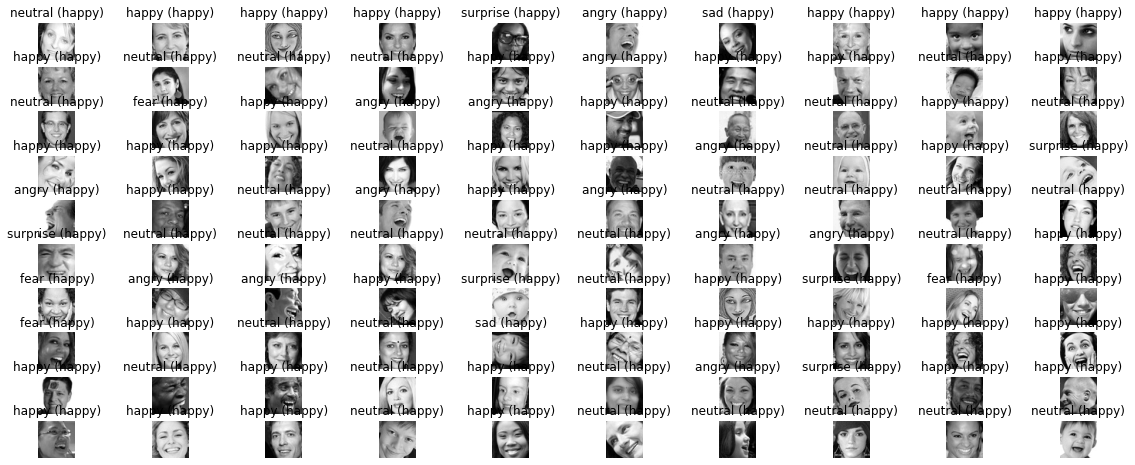

In [19]:
# Veri setinden bazı örneklere bakalım.
def plot_test_images(class_name, test_data_path, model):
    plt.figure(figsize=(10,16))
    
    class_labels = test_generator.class_indices
    figure = plt.figure(figsize=(20, 8))

    i=10
    j=10

    image_size=(48,48)

    for exp in os.listdir(test_data_path):
        if exp == class_name:
            full_path = os.path.join(test_data_path, class_name)
            images_path = glob.glob(os.path.join(full_path, '*.jpg'))
            for k in range(100):
                random_image_name = random.choice(images_path)
                #print(random_image_name)
                
                lst=[]
                c="\\"
                count=1
                i=1
                for pos,char in enumerate(random_image_name):
                    if(char == c and count==1):
                        random_image_name = random_image_name[:pos] + '\\' + random_image_name[pos:]
                        count+=1
                        #print(random_image_name)    
                    elif(char == c):
                        pos+=i
                        i+=1
                        random_image_name = random_image_name[:pos] + '\\' + random_image_name[pos:]
                        #print(random_image_name)
                        
                #print(random_image_name)

                img = image.load_img(random_image_name, target_size=(48,48), color_mode="grayscale")
                
                predict_class = prediction_on_test_image(model, img)
                
                true_index = class_name
                
                ax = figure.add_subplot(10, 10, k+1)
                ax.set_title("{} ({})".format((predict_class), (true_index)))
                plt.imshow(img, cmap="gray")
                plt.axis("off")
                
print("TRAIN")
plot_test_images("happy", test_data_path, model);

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


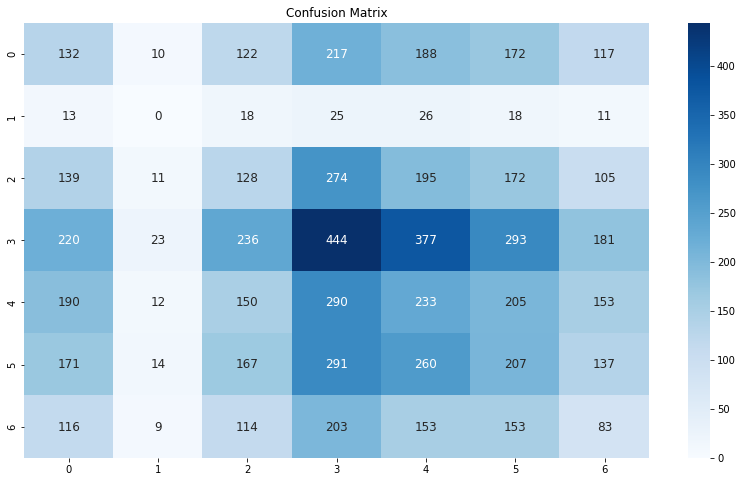

In [20]:
from sklearn.metrics import confusion_matrix

print(test_generator.class_indices)

y_pred = model.predict(test_generator)
pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(test_generator.classes, pred)
plt.figure(figsize = (14,8))
plt.title("Confusion Matrix")

ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 12})